In [2]:
from visualize import *

Visualizer


<AxesSubplot:>

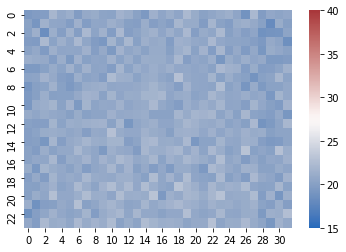

In [3]:
sns.heatmap(data[31,:,:,2] , cmap="vlag" , vmin=15 ,vmax=40)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import scipy.stats as sc

In [17]:
def gaussian_pdf(x , sigma , mu):
    pdf1 = (1/(sigma*np.sqrt(2*np.pi)))
    pdf2 = np.exp(-0.5*((x-mu)/sigma)**2)
    return pdf1*pdf2
n = 0.0015
mean = np.zeros((235,24,32,16))
mean[0,:,:,0] = np.copy(data[0,:,:,0])
sigma = 0.4
alpha = 0.0001
M = 0
gmean = np.zeros((235,24,32,16))
gp = np.zeros((235,24,32,16))
event = np.zeros((235,24,32,16))

for i in range(0,1):
    for j in range(0,1):
        for k in range(0,24):
            for l in range(0,32):
                event[i,k,l,j] = 1

for j in range(0,16):
    mean[0,:,:,0] = mean[0,:,:,0] + data[0,:,:,j]
for j in range(0,9):
    mean[0,:,:,0] = mean[0,:,:,0] + data[1,:,:,j]

mean[0,:,:,0] = mean[0,:,:,0]/25

fg = []
cnt = np.zeros((236,16))
bg = []
maxi = np.zeros((235,24,32,16))
mini = np.zeros((235,24,32,16))
mini[0,:,:,0] = data[0,:,:,0]
maxi[0,:,:,0] = data[0,:,:,0]
theta = 0.015
gamma = 0.2

In [18]:

for l in range(0,235):
    start = 0
    if l == 0:
        start = 1
    for k in range(start,16):
        for i in range(0,24):
            for j in range(0,32):
                if k==0:
                    mean[l,i,j,k] = alpha*data[l,i,j,k] + mean[l-1,i,j,15]*(1-alpha)        ## Mean if k==0 and l!=0
                    maxi[l,i,j,k] = max(maxi[l-1,i,j,15] , data[l,i,j,k])
                    mini[l,i,j,k] = min(mini[l-1,i,j,15] , data[l,i,j,k])
                else:
                    mean[l,i,j,k] = alpha*data[l,i,j,k] + mean[l,i,j,k-1]*(1-alpha)                  ## Mean if k!=0 and l!=0
                    maxi[l,i,j,k] = max(maxi[l,i,j,k-1] , data[l,i,j,k])
                    mini[l,i,j,k] = min(mini[l,i,j,k-1] , data[l,i,j,k])

                gp[l,i,j,k] = gaussian_pdf(data[l,i,j,k] , sigma , mean[l,i,j,k])                    ## Find the gaussian PDF 
                if gp[l,i,j,k]<n and data[l,i,j,k]>mean[0,i,j,0]:                                   ## Process is foreground
                    event[l,i,j,k] = 0
                    fg.append((data[l,i,j,k] , mean[l,i,j,k]))
                    if k!=0:
                        mean[l,i,j,k] = mean[l,i,j,k-1]                                       ## Update the mean if the process is foreground
                    else:
                        mean[l,i,j,k] = mean[l-1,i,j,15]

                else:
                    event[l,i,j,k] = 1   
                    bg.append((data[l,i,j,k] , mean[l,i,j,k]))                              ## Process is Background

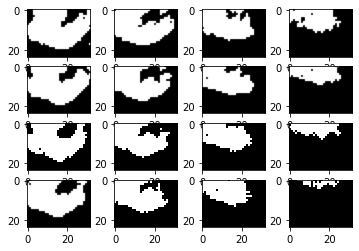

In [421]:
def visualize(second):
    fig, axs = plt.subplots(4, 4)
    frame = 0
    axs[0,0].imshow(mrf_event[second,:,:,frame] , cmap='Greys')
    axs[1,0].imshow(mrf_event[second,:,:,frame+1] , cmap='Greys')
    axs[2,0].imshow(mrf_event[second,:,:,frame+2] , cmap='Greys')
    axs[3,0].imshow(mrf_event[second,:,:,frame+3] , cmap='Greys')
    axs[0,1].imshow(mrf_event[second,:,:,frame+4] , cmap='Greys')
    axs[1,1].imshow(mrf_event[second,:,:,frame+5] , cmap='Greys')
    axs[2,1].imshow(mrf_event[second,:,:,frame+6] , cmap='Greys')
    axs[3,1].imshow(mrf_event[second,:,:,frame+7] , cmap='Greys')
    axs[0,2].imshow(mrf_event[second,:,:,frame+8] , cmap='Greys')
    axs[1,2].imshow(mrf_event[second,:,:,frame+9] , cmap='Greys')
    axs[2,2].imshow(mrf_event[second,:,:,frame+10] , cmap='Greys')
    axs[3,2].imshow(mrf_event[second,:,:,frame+11] , cmap='Greys')
    axs[0,3].imshow(mrf_event[second,:,:,frame+12] , cmap='Greys')
    axs[1,3].imshow(mrf_event[second,:,:,frame+13] , cmap='Greys')
    axs[2,3].imshow(mrf_event[second,:,:,frame+14] , cmap='Greys')
    axs[3,3].imshow(mrf_event[second,:,:,frame+15] , cmap='Greys')
visualize(223)

In [20]:
# Eradicate uncessesary foreground pixels by using the Markov Random Field model

diff = np.zeros((235,24,32,16))
mrf_event = np.zeros((235,24,32,16))
mrf_event[0,:,:,0] = 1
for l in range(0,235):
    for k in range(0,16):
        for i in range(0,24):
            for j in range(0,32):
                qf = 0
                qb = 0
                ratio = gp[l,i,j,k]*25      
                if i>0 and j>0:
                    if event[l,i-1,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i>0:
                    if event[l,i-1,j,k] == 0:
                        qf = qf+1
                    else:
                        qb = qb+1
                if j<31 and i>0:
                    if event[l,i-1,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if j>0:
                    if event[l,i,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if j<31:
                    if event[l,i,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23 and j>0:
                    if event[l,i+1,j-1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23:
                    if event[l,i+1,j,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1
                if i<23 and j<31:
                    if event[l,i+1,j+1,k] == 0:
                        qf = qf + 1
                    else:
                        qb = qb + 1

                mrf = theta * np.exp((qf-qb)/gamma)
                if ratio < mrf and data[l,i,j,k] > mean[l,i,j,k] and data[l,i,j,k] > mean[0,i,j,0]:
                    mrf_event[l,i,j,k] = 0
                    cnt[l,k] = cnt[l,k] + 1
                else:
                    mrf_event[l,i,j,k] = 1
                diff[l,i,j,k] = ratio-mrf


In [19]:
for i in range(0,235):
    for j in range(0,16):
        if cnt[i,j] > 50:
            print(i,j)

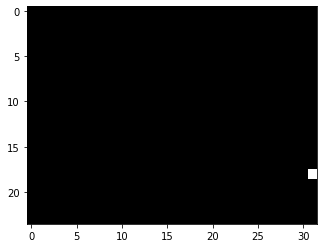

In [16]:
plt.imshow(mrf_event[91,:,:,2] , cmap='Greys')

In [486]:
cnt[209,12]

407.0

In [11]:
# Blob detection
# Use Recursive Blob Detection method (Similar to DBSCAN)
L = 100
K = 100
def blob_detector(i, j, visited, color, second, frame):
    '''
    Given a frame after BS, detects "blobs"
    '''
    
    blob_size = 1
    if visited[i,j] != 0 or mrf_event[second,i,j,frame] == 1:
        return 0
    
    record.append((i,j,color))
    visited[i,j] = color
    connected = 0
    if i>0 and j>0 and mrf_event[second,i-1,j-1,frame] == 0 and visited[i-1,j-1] == 0:
        blob_size = blob_size + blob_detector(i-1,j-1,visited,color,second,frame)
        connected = connected + 1
        
    if i>0 and mrf_event[second,i-1,j,frame] == 0 and visited[i-1,j] == 0:
        blob_size  = blob_size + blob_detector(i-1,j,visited,color,second,frame)
        connected = connected + 1
       
    if j<31 and i>0 and mrf_event[second,i-1,j+1,frame] == 0 and visited[i-1,j+1] == 0:
        blob_size  = blob_size + blob_detector(i-1,j+1,visited,color,second,frame)
        connected = connected + 1
       
    if j>0 and mrf_event[second,i,j-1,frame] == 0 and visited[i,j-1] == 0:
        blob_size  = blob_size + blob_detector(i,j-1,visited,color,second,frame)
        connected = connected + 1
       
    if j<31 and mrf_event[second,i,j+1,frame] == 0 and visited[i,j+1] == 0:
        blob_size  = blob_size + blob_detector(i,j+1,visited,color,second,frame)
        connected = connected + 1
        
    if i<23 and j>0 and mrf_event[second,i+1,j-1,frame] == 0 and visited[i+1,j-1] == 0:
        blob_size  = blob_size + blob_detector(i+1,j-1,visited,color,second,frame)
        connected = connected + 1
       
    if i<23 and mrf_event[second,i+1,j,frame] == 0 and visited[i+1,j] == 0:
        blob_size  = blob_size + blob_detector(i+1,j,visited,color,second,frame)
        connected = connected + 1
       
    if i<23 and j<31 and mrf_event[second,i+1,j+1,frame] == 0 and visited[i+1,j+1] == 0:
        blob_size  = blob_size + blob_detector(i+1,j+1,visited,color,second,frame)
        connected = connected + 1
  
    return blob_size

visited = np.zeros((24,32))
blobs = []
record = []
color = 1
for i in range(0,24):
    for j in range(0,32):
        size = blob_detector(i,j,visited,color,10,15)
        if size>100:
            blobs.append((i,j,size))
            color = color+1
        




In [12]:
print("Blobs" , blobs)
print("Record Shape" , np.shape(record))

Blobs []
Record Shape (0,)


In [425]:
blobs = []
for l in range(0,235):
    for k in range(0,16):
        if cnt[l,k] < K:
            continue
        record = []
        color = 1
        visited = np.zeros((24,32))
        for i in range(0,24):
            for j in range(0,32):
                size = blob_detector(i,j,visited,color,l,k)
                if size>=L:
                    color = color + 1
        blobs.append((l,k,color-1,record))

In [240]:
cnt[11,2]

191.0

In [427]:
print(blobs[0][2])

1


In [428]:
input1 = int(input("Enter second"))
input2 = int(input("Enter frame"))
print("----------------------------------------------")
print("-------------Blob information-----------------")
print("Second: " , input1)
print("Frame: ", input2)
flag = -1
for i in range(len(blobs)):
    if blobs[i][0] == input1-1 and blobs[i][1] == input2-1:
        flag = i

if flag == -1:
    print("No blobs in the requested frame!")
else:
    print("Number of Blobs: " , blobs[flag][2])
    print("Blob indices along with their color: " , blobs[flag][3])
print("----------------------------------------------")

----------------------------------------------
-------------Blob information-----------------
Second:  211
Frame:  16
Number of Blobs:  2
Blob indices along with their color:  [(0, 5, 1), (0, 6, 1), (0, 7, 1), (0, 8, 1), (0, 9, 1), (0, 10, 1), (0, 11, 1), (0, 12, 1), (0, 13, 1), (0, 14, 1), (0, 15, 1), (0, 16, 1), (0, 17, 1), (0, 18, 1), (0, 19, 1), (0, 20, 1), (1, 19, 1), (1, 18, 1), (1, 17, 1), (1, 16, 1), (1, 15, 1), (1, 14, 1), (1, 13, 1), (1, 12, 1), (1, 11, 1), (1, 10, 1), (1, 9, 1), (1, 8, 1), (1, 7, 1), (1, 6, 1), (1, 5, 1), (1, 4, 1), (2, 3, 1), (2, 2, 1), (3, 2, 1), (3, 3, 1), (2, 4, 1), (2, 5, 1), (2, 6, 1), (2, 7, 1), (2, 8, 1), (2, 9, 1), (2, 10, 1), (2, 11, 1), (2, 12, 1), (2, 13, 1), (2, 14, 1), (2, 15, 1), (2, 16, 1), (2, 17, 1), (2, 18, 1), (2, 19, 1), (1, 20, 1), (1, 21, 1), (2, 20, 1), (2, 21, 1), (2, 22, 1), (3, 21, 1), (3, 20, 1), (3, 19, 1), (3, 18, 1), (3, 17, 1), (3, 16, 1), (3, 15, 1), (3, 14, 1), (3, 13, 1), (3, 12, 1), (3, 11, 1), (3, 10, 1), (3, 9, 1), (3, 8

In [333]:
# Use the obtained information in order to calculate centroid
# For a given frame, in order to calculate the centroid, we get the information on how many blobs are present

blob_frames = np.shape(blobs)[0]
centroids = []

for i in range(0,blob_frames):
    colors = blobs[i][2]
    j = 1
    frame_centroids = []
    while j <= colors:
        local_centroid_x = 0
        local_centroid_y = 0
        numb = 0
        for k in range(0,len(blobs[i][3])):
            if blobs[i][3][k][2] == j:
                local_centroid_x = local_centroid_x + blobs[i][3][k][0]
                local_centroid_y = local_centroid_y + blobs[i][3][k][1]
                numb = numb + 1
        local_centroid_x = local_centroid_x/numb
        local_centroid_y = local_centroid_y/numb
        frame_centroids.append((j , local_centroid_x , local_centroid_y))
        j = j+1
    if blobs[i][2] != 0:
        centroids.append((blobs[i][0],blobs[i][1],blobs[i][2],frame_centroids))





In [334]:
np


<module 'numpy' from '/usr/local/lib/python3.8/site-packages/numpy/__init__.py'>

In [335]:
print(centroids[0])

(10, 15, 1, [(1, 5.934782608695652, 4.978260869565218)])


In [336]:

print(len(centroids))
for i in range(1,len(centroids)-1):
    second = centroids[i][0]
    frame = centroids[i][1]
    if second != centroids[i-1][0] or second != centroids[i+1][0]:
        if (centroids[i-1][1] == 15 and frame == 0) or (centroids[i+1][1] == 0 and frame == 15):
            continue
        elif np.abs(centroids[i-1][0] - second) > 1 and np.abs(centroids[i+1][0] - second) > 1:
            centroids.remove(centroids[i])
            continue
    elif frame != centroids[i-1][1] + 1 or frame != centroids[i+1][1] - 1:
        if (np.abs(centroids[i-1][1] - frame) > 10 and np.abs(cnt[centroids[i-1][0] , centroids[i-1][1]] - cnt[second , frame]) > 100) or (np.abs(centroids[i+1][1] - frame) > 10 and np.abs(cnt[centroids[i+1][0] , centroids[i+1][1]] - cnt[second , frame]) > 100):
            centroids.remove(centroids[i])
    

print(len(centroids))


        

976
976


In [337]:
cnt[211,8]

383.0

In [677]:
def blob_size(input1 , input2):
    '''
    Given a frame and a second, returns the foreground pixels which are part of a blob
    '''
    flag = -1
    for i in range(len(blobs)):
        if blobs[i][0] == input1 and blobs[i][1] == input2:
            flag = i
    return np.shape(blobs[flag][3])[0]

# In this section of code, we count the number of people entering and exitting in the room
# We use the centroids calculated in the previous section in order to count the number of people

print("Counting the number of people \n")

# Before we count the number of people, we remove centroids which are likely due to incorrect readings by the sensor
# We do so by checking the consecutiveness of the frames in the centroid list we obtained

before_outlier = np.shape(centroids)

for i in range(1,len(centroids)-1):
    second = centroids[i][0]
    frame = centroids[i][1]
    if second != centroids[i-1][0] or second != centroids[i+1][0]:
        if (centroids[i-1][1] == 15 and frame == 0) or (centroids[i+1][1] == 0 and frame == 15):
            continue
        elif np.abs(centroids[i-1][0] - second) > 1 and np.abs(centroids[i+1][0] - second) > 1:
            centroids.remove(centroids[i])
            continue
    elif frame != centroids[i-1][1] + 1 or frame != centroids[i+1][1] - 1:
        if (np.abs(centroids[i-1][1] - frame) > 10 and np.abs(cnt[centroids[i-1][0] , centroids[i-1][1]] - cnt[second , frame]) > 100) or (np.abs(centroids[i+1][1] - frame) > 10 and np.abs(cnt[centroids[i+1][0] , centroids[i+1][1]] - cnt[second , frame]) > 100):
            centroids.remove(centroids[i])

after_outlier = np.shape(centroids)

if before_outlier == after_outlier:
    print("No outliers \n")

else:
    print("Outliers removed \n")

# Once the outliers are removed, we start the process of counting.
# For counting, we majorly use the 'y' axes of the centroid. If we notice the y axes moving , we count an entry/exit
# Initialize the parameters
entry = []
exits = []
count = 0 
mapping_verbrose = []
mapping_verbrose.append((0,[],[1]))
# Start the counting process
for i in range(1,len(centroids)):
    unmapped = []
    mapped = []
    condition = -1
    if (not (centroids[i][0] == centroids[i-1][0] + 1 and centroids[i][1] == 0 and centroids[i-1][1] == 15)) and np.abs(centroids[i][0] - centroids[i-1][0]) >= 1:
        '''
        New blob(s) is/are born; track it
        '''
        for j in range(1 , centroids[i][2] + 1):
            condition = 0
            unmapped.append(j)                          # We are assuming we will be mapping every unmapped centroid in its next frame.
           
    elif centroids[i-1][2] < centroids[i][2]:

        '''
        New blob is incoming while the existing blob is present / New blob disintegrated from the previous blobs; map accordingly or the centroids merged
        '''
        if centroids[i-1][2] == 1 and centroids[i][2] > 1:
            '''
            Blobs may have disintegrated
            '''
            condition = 1
            mapped, unmapped = mapping(centroids[i] , centroids[i-1] , 1)
        else:
            mapped , unmapped = mapping(centroids[i] , centroids[i-1] , 2)
        
    elif centroids[i-1][2] == centroids[i][2]:
        '''
        The number of blobs are the same, map accordingly
        '''
        condition = 3
        mapped,unmapped = mapping(centroids[i] , centroids[i-1] , 3)


    elif centroids[i-1][2] > centroids[i][2]:
        '''
        Some of the blobs may have passed , count their entry/exit ; map accordingly
        '''
        if centroids[i][2] == 1 and centroids[i-1][2] > 1:
            condition = 4
            mapped,unmapped = mapping(centroids[i] , centroids[i-1] , 4)

        else:
            condition = 5
            mapped,unmapped = mapping(centroids[i] , centroids[i-1] , 5)
     
    mapping_verbrose.append((i , mapped , unmapped))
    


Counting the number of people 

No outliers 



In [676]:
def mapping(centroid1 , centroid2 , condition):
    '''
    Given the conditions, map the centroid
    '''

    map = []
    unmapped = []
    if condition == 1:
        '''
        Blobs may have disintegrated
        '''
        if np.abs(blob_size(centroid1[0] , centroid1[1]) - blob_size(centroid2[0] , centroid2[1])) <= 50:
            '''
            Blobs have merged
            '''
            for j in range(1,centroid1[2] + 1):
                map.append((j , 1))
        else:
            condition = 2

    if condition == 2:
        '''
        New blob born when blobs are present
        '''
        visited = np.zeros(centroid2[2])
        for i in range(1,centroid1[2] + 1):
            mini = 1e9+7
            map_cur = i
            map_prev = -1
            for j in range(1,centroid2[2]+1):
                if visited[j-1] == 0:
                    dist = (centroid1[3][i-1][1]-centroid2[3][j-1][1])**2 + (centroid1[3][i-1][2]-centroid2[3][j-1][2])**2
                    if mini>dist:
                        mini = dist
                        map_prev = j
            visited[map_prev-1] = 1
            map.append((map_cur , map_prev))

        for i in range(1,centroid1[2] + 1):
            found = -1
            for j in map:
                if i == j[0]:
                    found = 1
            if found == -1:
                unmapped.append(i)

    if condition == 3:
        '''
        The number of blobs are the same
        '''
        visited = np.zeros(centroid2[2])
        for i in range(1,centroid1[2] + 1):
            mini = 1e9+7
            map_cur = i
            map_prev = -1
            for j in range(1,centroid2[2]+1):
                if visited[j-1] == 0:
                    dist = (centroid1[3][i-1][1]-centroid2[3][j-1][1])**2 + (centroid1[3][i-1][2]-centroid2[3][j-1][2])**2
                    if mini>dist:
                        mini = dist
                        map_prev = j
            visited[map_prev-1] = 1
            map.append((map_cur , map_prev))
    
    if condition == 4:
        '''
        Some of the blobs have passed; tricky edge case. We need to comapre the size of the blobs. 
        '''

        if np.abs(blob_size(centroid1[0] , centroid1[1]) - blob_size(centroid2[0] , centroid2[1])) <= 50:
            '''
            Blobs have merged
            '''

            for j in range(1,centroid2[2]+1):
                map.append((1 , j))
        
        else:
            '''
            Revert to condition 5
            '''
            condition = 5

    if condition == 5:
        '''
        Blobs are dissapearing; we now find which blob diappeared 
        '''
        visited = np.zeros(centroid2[2])
        for i in range(1,centroid1[2] + 1):
            mini = 1e9+7
            map_cur = i
            map_prev = -1
            for j in range(1,centroid2[2]+1):
                if visited[j-1] == 0:
                    dist = (centroid1[3][i-1][1]-centroid2[3][j-1][1])**2 + (centroid1[3][i-1][2]-centroid2[3][j-1][2])**2
                    if mini>dist:
                        mini = dist
                        map_prev = j
            visited[map_prev-1] = 1
            map.append((map_cur , map_prev))

        for i in range(1,centroid2[2] + 1):
            found = -1
            for j in map:
                if i == j[1]:
                    found = 1
            if found == -1:
                unmapped.append(i) 

    return (map , unmapped)
    

In [675]:
centroids[2]

(11, 1, 1, [(1, 12.137055837563452, 5.720812182741117)])

In [692]:
# In this section, we count the number of people using the mapping and centroid arrays obtained from the previously obtained centroid and mapping lists
# We also take care of the "lingering condition over here"

print("Counting the number of people \n")

# In order to count the number of people entering and exiting the room , we use the centroid.
# If the y-axes of the centroid (n-1) is at the top and moves to the bottom in the next frame, then the person is moving into the room (entering)
# Else, if it is the latter case, the person is exitting the room

entry = 0
exit = 0
indices = []
for i in range(1 , np.shape(centroids)[0]):

    '''
    Check if the blob belongs to the same cluster a previous blob
    '''
    if np.shape(mapping_verbrose[i][2])[0] != 0:
        '''
        New blobs formed ; continue
        '''
        continue
    else:
        '''
        Analyse the mappings
        '''
        for j in range(1, centroids[i][2] + 1):

            cur = mapping_verbrose[i][1][j-1][0]
            prev = mapping_verbrose[i][1][j-1][1]

            if centroids[i][3][cur-1][2] > 16 and centroids[i-1][3][prev-1][2] < 16:
                entry = entry + 1
                indices.append(i)

            elif centroids[i][3][cur-1][2] < 16 and centroids[i-1][3][prev-1][2] > 16:
                exit = exit + 1
                indices.append(i)
print(entry , exit)



Counting the number of people 

24 23
